In [1]:
import pandas as pd
from scipy.stats import ks_2samp
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
plt.rc('font', family='serif') # change font types for plots
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

# Which feature has the highest KS value, and in what topology?

In [12]:
#load data
df = pd.read_csv("./dataframes/df_aggregated_spc.csv")
df['stabilityscore_cnn_calibrated_2classes'] = df['stabilityscore_cnn_calibrated'] > 1

#NTF2 topology should not be used so remove those rows
ntf2_inx = df[df['topology']=='NTF2'].index
df = df.drop(ntf2_inx)

In [13]:
#get list names for entropy features
spc_features = pd.read_csv('./entropy_features.csv')["0"].to_list()

#get lsit names for rosetta features
ros_features = pd.read_csv('./rosetta_features.csv')["0"].to_list()
#create a list of all topologies
topologies = list(df['topology'].unique())

#split up dataframe into stable and unstable proteins
stable_proteins = df[df['stabilityscore_cnn_calibrated_2classes']==1]
unstable_proteins = df[df['stabilityscore_cnn_calibrated_2classes']==0]

In [14]:
highest_value = 0
best_topology = None
best_feature = None

for topology in topologies:
    stable_proteins_topology = stable_proteins[stable_proteins['topology']==topology]
    unstable_proteins_topology = unstable_proteins[unstable_proteins['topology']==topology]
    for feature in spc_features:
        ks_val, _ = ks_2samp(stable_proteins_topology[feature],unstable_proteins_topology[feature])
        if ks_val > highest_value:
            highest_value = ks_val
            best_topology=topology
            best_feature = feature
        


In [15]:
# best topology + feature to look at in topology-specific model
print(highest_value)
print(best_topology)
print(best_feature)

0.4217523112707249
EEHEE
SumE_entropies


In [16]:
# best feature to look at in general model
highest_value = 0
best_feature = None

for feature in spc_features:
#     print("Feature -> %s"%feature)
    ks_val, _ = ks_2samp(stable_proteins[feature],unstable_proteins[feature])
#     print("KS VAL --> %0.2f"%ks_val)
    if ks_val > highest_value:
        highest_value = ks_val
        best_feature = feature
#     print("**")
#     print("highest value --> %0.2f"%highest_value)
#     print("best_feature --> %s" %best_feature)
#     print("**\n")



In [17]:
print(highest_value)
print(best_feature)

0.23371905860097097
E_max_entropy


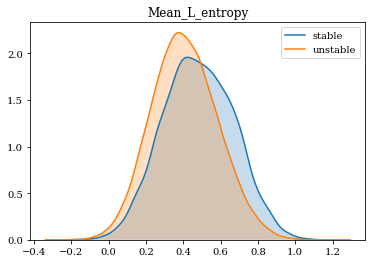

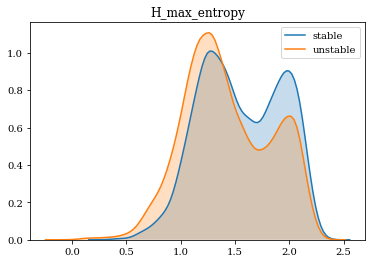

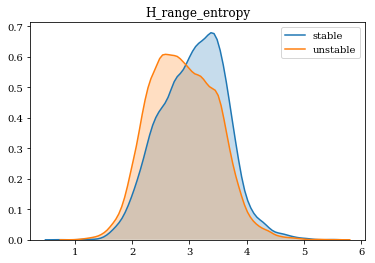

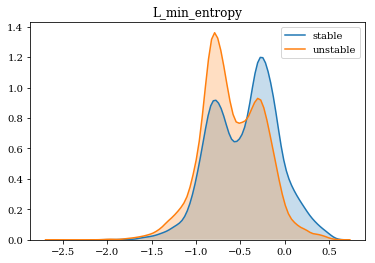

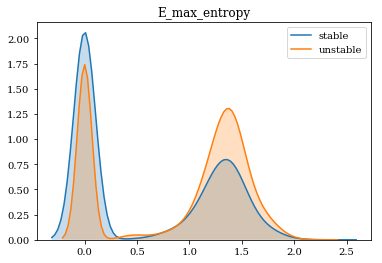

In [18]:
fet_to_plot = ["Mean_L_entropy", "H_max_entropy", "H_range_entropy", "L_min_entropy","E_max_entropy"]
for fet in fet_to_plot:
    sns.kdeplot(stable_proteins[fet],label='stable',shade=True)
    sns.kdeplot(unstable_proteins[fet],label='unstable',shade=True)
    plt.title("%s"%fet)
    plt.show()
    plt.close('all')

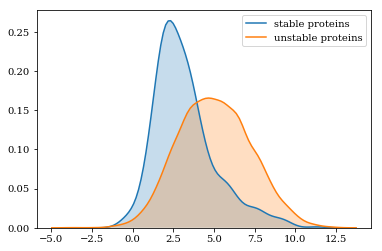

In [19]:
topology = 'EEHEE'
feature = 'SumE_entropies'

stable_proteins_top_specific = stable_proteins[stable_proteins['topology']==topology]
unstable_proteins_top_specific = unstable_proteins[unstable_proteins['topology']==topology]

sns.kdeplot(stable_proteins_top_specific[feature],label='stable proteins',shade=True)
sns.kdeplot(unstable_proteins_top_specific[feature],label='unstable proteins',shade=True)

## I'm going to do the same thing above but for Rosetta features

In [20]:
highest_value = 0
best_topology = None
best_feature = None

for topology in topologies:
    stable_proteins_topology = stable_proteins[stable_proteins['topology']==topology]
    unstable_proteins_topology = unstable_proteins[unstable_proteins['topology']==topology]
    for feature in ros_features:
        ks_val, _ = ks_2samp(stable_proteins_topology[feature],unstable_proteins_topology[feature])
        if ks_val > highest_value:
            highest_value = ks_val
            best_topology=topology
            best_feature = feature
        


# best topology + feature to look at in topology-specific model
print("BEST TOPOLOGY+FEATURE")
print(highest_value)
print(best_topology)
print(best_feature)

# best feature to look at in general model
highest_value = 0
best_feature = None

print("BEST FEATURE")
for feature in ros_features:
        ks_val, _ = ks_2samp(stable_proteins[feature],unstable_proteins[feature])
        if ks_val > highest_value:
            highest_value = ks_val
            best_feature = feature
        


print(highest_value)
print(best_feature)

KeyboardInterrupt: 

In [ ]:
fet_to_plot = ["avg_best_frag"]
for fet in fet_to_plot:
    sns.kdeplot(stable_proteins[fet],label='stable',shade=True)
    sns.kdeplot(unstable_proteins[fet],label='unstable',shade=True)
    plt.title("%s"%fet)
    plt.show()
    plt.close('all')

In [ ]:
import matplotlib
cmap = matplotlib.cm.get_cmap('tab10')
cmap

In [36]:
cmap(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

Text(0.5, 1.0, 'contig_not_hp_avg')

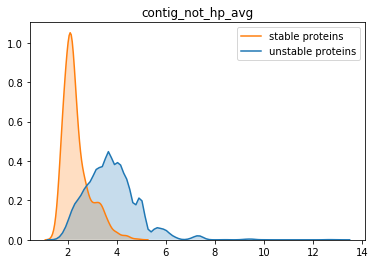

In [37]:
topology = 'EEHEE'
feature = 'contig_not_hp_avg'

stable_proteins_top_specific = stable_proteins[stable_proteins['topology']==topology]
unstable_proteins_top_specific = unstable_proteins[unstable_proteins['topology']==topology]

sns.kdeplot(stable_proteins_top_specific[feature],label='stable proteins',shade=True,c=cmap(1))
sns.kdeplot(unstable_proteins_top_specific[feature],label='unstable proteins',shade=True,c=cmap(0))
plt.title("%s"%feature)

# Do entropy features make models more selective?
- will check by comparing False Positive rates
- **Hypothesis**: entropy features make FP count decrease

So a challenge is that the testing dataframes output by the TH don't include
information on whether the model was RS or R. To go around this, I will load the
`classification leaderboard` (which does contain this info) and get an index of runs
which are for rosetta, with the goal of making a dataframe specifically for the rosetta 
tptn results. 

In [21]:
def get_tptn_data(dataframe, 
                  real_value='stabilityscore_cnn_calibrated_2classes',
                 predicted_value='stabilityscore_cnn_calibrated_2classes_predictions',return_count=True):
    #get all 0's and all 1's
    positives = dataframe[dataframe['stabilityscore_cnn_calibrated_2classes']==1]
    negatives = dataframe[dataframe['stabilityscore_cnn_calibrated_2classes']==0]


    tp = positives[positives['stabilityscore_cnn_calibrated_2classes_predictions']==1]
    tn = negatives[negatives['stabilityscore_cnn_calibrated_2classes_predictions']==0]

    fp = negatives[negatives['stabilityscore_cnn_calibrated_2classes_predictions']==1]
    fn = positives[positives['stabilityscore_cnn_calibrated_2classes_predictions']==0]
    if return_count !=True:
        return tp,tn,fp,fn
    return len(tp),len(tn),len(fp),len(fn)

In [22]:
#load leaderboard
leaderboard = pd.read_html('./estrada_runs/cross_val_tptn_runs/test_harness_results/custom_classification_leaderboard.html')[0]

In [23]:
#get names of rosetta runs
rosetta_runs = leaderboard[leaderboard['Data and Split Description']=='R']
rosetta_runs_names = list(rosetta_runs['Run ID'].values)

#get names of R+S runs
entropy_rosetta_runs = leaderboard[leaderboard['Data and Split Description']=='RS']
entropy_rosetta_runs_names = list(entropy_rosetta_runs['Run ID'].values)

### Rosetta Model TPTN data extraction

In [41]:
# "R" Model

#initialize dataframe that will contain data
ros_df = pd.DataFrame()
ros_df['TP Count'] = []
ros_df['FP Count'] = []
ros_df['TN Count'] = []
ros_df['FN Count'] = []

#initialize empty lists for data
ros_tp_data = []
ros_tn_data = []
ros_fp_data = []
ros_fn_data = []

#loop through files
for run_name in rosetta_runs_names:
    df = pd.read_csv('./estrada_runs/cross_val_tptn_runs/test_harness_results/runs/run_%s/testing_data.csv'%run_name)
    tp,tn,fp,fn = get_tptn_data(df)

    #update the lists
    ros_tp_data.append(tp)
    ros_tn_data.append(tn)
    ros_fp_data.append(fp)
    ros_fn_data.append(fn)

#construct final dataframe
ros_df['TP Count'] = ros_tp_data
ros_df['FP Count'] = ros_fp_data
ros_df['FN Count'] = ros_fn_data
ros_df['TN Count'] = ros_tn_data

In [42]:
ros_df.describe()

,TP Count,FP Count,TN Count,FN Count
count,100.000000,100.000000,100.000000,100.000000
mean,1586.390000,1306.610000,12427.390000,731.610000
std,5.132379,8.461314,8.461314,5.132379
min,1575.000000,1288.000000,12406.000000,717.000000
25%,1583.000000,1300.000000,12422.000000,728.000000
50%,1587.000000,1306.000000,12428.000000,731.000000
75%,1590.000000,1312.000000,12434.000000,735.000000
max,1601.000000,1328.000000,12446.000000,743.000000


### Rosetta+Entropy Model TPTN data extraction

In [43]:
# "R+S" Model

#initialize dataframe that will contain data
spc_df = pd.DataFrame()
spc_df['TP Count'] = []
spc_df['FP Count'] = []
spc_df['TN Count'] = []
spc_df['FN Count'] = []

#initialize empty lists for data
spc_tp_data = []
spc_tn_data = []
spc_fp_data = []
spc_fn_data = []

#loop through files
for run_name in entropy_rosetta_runs_names:
    df = pd.read_csv('./estrada_runs/cross_val_tptn_runs/test_harness_results/runs/run_%s/testing_data.csv'%run_name)
    tp,tn,fp,fn = get_tptn_data(df)

    #update the lists
    spc_tp_data.append(tp)
    spc_tn_data.append(tn)
    spc_fp_data.append(fp)
    spc_fn_data.append(fn)

#construct final dataframe
spc_df['TP Count'] = spc_tp_data
spc_df['FP Count'] = spc_fp_data
spc_df['FN Count'] = spc_fn_data
spc_df['TN Count'] = spc_tn_data


In [44]:
spc_df.describe()

,TP Count,FP Count,TN Count,FN Count
count,100.00000,100.000000,100.000000,100.00000
mean,1565.84000,1261.640000,12472.360000,752.16000
std,6.30331,9.053734,9.053734,6.30331
min,1551.00000,1235.000000,12453.000000,735.00000
25%,1562.00000,1255.500000,12466.750000,748.00000
50%,1565.00000,1262.000000,12472.000000,753.00000
75%,1570.00000,1267.250000,12478.500000,756.00000
max,1583.00000,1281.000000,12499.000000,767.00000


In [45]:
results = spc_df.describe() - ros_df.describe()
results.iloc[1,:]

TP Count   -20.55
FP Count   -44.97
TN Count    44.97
FN Count    20.55
Name: mean, dtype: float64

In [46]:
results

,TP Count,FP Count,TN Count,FN Count
count,0.000000,0.00000,0.00000,0.000000
mean,-20.550000,-44.97000,44.97000,20.550000
std,1.170931,0.59242,0.59242,1.170931
min,-24.000000,-53.00000,47.00000,18.000000
25%,-21.000000,-44.50000,44.75000,20.000000
50%,-22.000000,-44.00000,44.00000,22.000000
75%,-20.000000,-44.75000,44.50000,21.000000
max,-18.000000,-47.00000,53.00000,24.000000


# Remaking of Scatter Plots

In [47]:
# main dataframe 
df = pd.read_csv('./dataframes/df_aggregated_spc.csv')
df['stabilityscore_cnn_calibrated_2classes'] = df['stabilityscore_cnn_calibrated'] > 1

#NTF2 topology should not be used so remove those rows
ntf2_inx = df[df['topology']=='NTF2'].index
df = df.drop(ntf2_inx)

In [48]:
#get a run that was just rosetta
sample_ros_run = rosetta_runs_names[0]
#get the index of names that were in that run's testing data
ros_scatter_data = pd.read_csv('./estrada_runs/cross_val_tptn_runs/test_harness_results/runs/run_%s/testing_data.csv'%sample_ros_run)
ros_data_inx = ros_scatter_data['name'].to_list()

In [49]:
#get a slice the dataframe which contains only the testing data
ros_slice = df[df['name'].isin(ros_data_inx)].copy()
ros_slice['stabilityscore_cnn_calibrated_2classes_predictions'] = ros_scatter_data['stabilityscore_cnn_calibrated_2classes_predictions'].values

In [50]:
#specify for topology
ros_slice = ros_slice[ros_slice['topology']=='EEHEE']

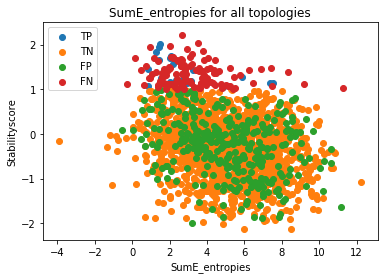

In [51]:
tp,tn,fp,fn = get_tptn_data(ros_slice,return_count=False)

fig, ax = plt.subplots()

plt.scatter(x=tp['SumE_entropies'].values, y=tp['stabilityscore_cnn_calibrated'].values,label='TP')
plt.scatter(x=tn['SumE_entropies'].values, y=tn['stabilityscore_cnn_calibrated'].values,label='TN')
plt.scatter(x=fp['SumE_entropies'].values, y=fp['stabilityscore_cnn_calibrated'].values,label='FP')
plt.scatter(x=fn['SumE_entropies'].values, y=fn['stabilityscore_cnn_calibrated'].values,label='FN')

plt.title('SumE_entropies for all topologies')
plt.xlabel('SumE_entropies')
plt.ylabel('Stabilityscore')
plt.legend()


In [52]:
#get a run that was just rosetta
sample_spc_run = entropy_rosetta_runs_names[0]
#get the index of names that were in that run's testing data
spc_scatter_data = pd.read_csv('./estrada_runs/cross_val_tptn_runs/test_harness_results/runs/run_%s/testing_data.csv'%sample_spc_run)
spc_data_inx = spc_scatter_data['name'].to_list()

#get a slice the dataframe which contains only the testing data
spc_slice = df[df['name'].isin(spc_data_inx)].copy()
spc_slice['stabilityscore_cnn_calibrated_2classes_predictions'] = spc_scatter_data['stabilityscore_cnn_calibrated_2classes_predictions'].to_list()


#specify for topology
spc_slice = spc_slice[spc_slice['topology']=='EHEE']

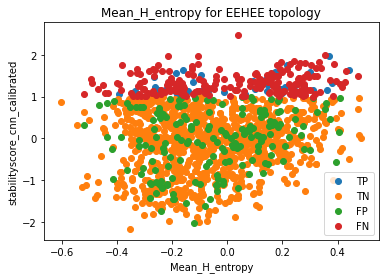

In [53]:
tp,tn,fp,fn = get_tptn_data(spc_slice,return_count=False)
feature = 'Mean_H_entropy'
y_axis_col = 'stabilityscore_cnn_calibrated'

fig, ax = plt.subplots()

plt.scatter(x=tp[feature].values, y=tp[y_axis_col].values,label='TP')
plt.scatter(x=tn[feature].values, y=tn[y_axis_col].values,label='TN')
plt.scatter(x=fp[feature].values, y=fp[y_axis_col].values,label='FP')
plt.scatter(x=fn[feature].values, y=fn[y_axis_col].values,label='FN')

plt.title('Mean_H_entropy for EEHEE topology')
plt.xlabel('Mean_H_entropy')
plt.ylabel('stabilityscore_cnn_calibrated')

plt.legend()

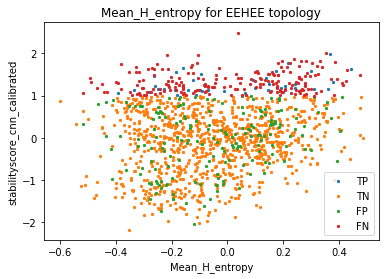

In [54]:
tp,tn,fp,fn = get_tptn_data(spc_slice,return_count=False)
feature = 'Mean_H_entropy'
y_axis_col = 'stabilityscore_cnn_calibrated'

fig, ax = plt.subplots()

plt.scatter(x=tp[feature].values, y=tp[y_axis_col].values,label='TP',s=5)
plt.scatter(x=tn[feature].values, y=tn[y_axis_col].values,label='TN',s=5)
plt.scatter(x=fp[feature].values, y=fp[y_axis_col].values,label='FP',s=5)
plt.scatter(x=fn[feature].values, y=fn[y_axis_col].values,label='FN',s=5)

plt.title('Mean_H_entropy for EEHEE topology')
plt.xlabel('Mean_H_entropy')
plt.ylabel('stabilityscore_cnn_calibrated')

plt.legend()

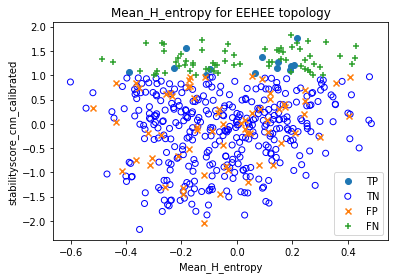

In [55]:
tp,tn,fp,fn = get_tptn_data(spc_slice.sample(500),return_count=False)
feature = 'Mean_H_entropy'
y_axis_col = 'stabilityscore_cnn_calibrated'

fig, ax = plt.subplots()

plt.scatter(x=tp[feature].values, y=tp[y_axis_col].values,label='TP',marker='o')
plt.scatter(x=tn[feature].values, y=tn[y_axis_col].values,label='TN',facecolors='none',edgecolors='b')
plt.scatter(x=fp[feature].values, y=fp[y_axis_col].values,label='FP',marker='x')
plt.scatter(x=fn[feature].values, y=fn[y_axis_col].values,label='FN',marker='+')

plt.title('Mean_H_entropy for EEHEE topology')
plt.xlabel('Mean_H_entropy')
plt.ylabel('stabilityscore_cnn_calibrated')

plt.legend()

In [56]:
len(spc_slice)

1329

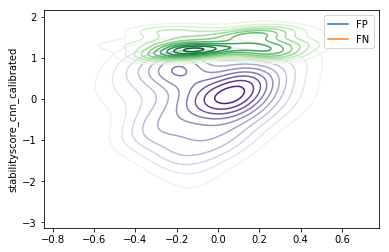

In [57]:
sns.kdeplot(fp[feature].values, fp[y_axis_col], cmap="Purples", shade=False,label='FP')
sns.kdeplot(fn[feature].values, fn[y_axis_col], cmap="Greens", shade=False,label='FN')
plt.legend()


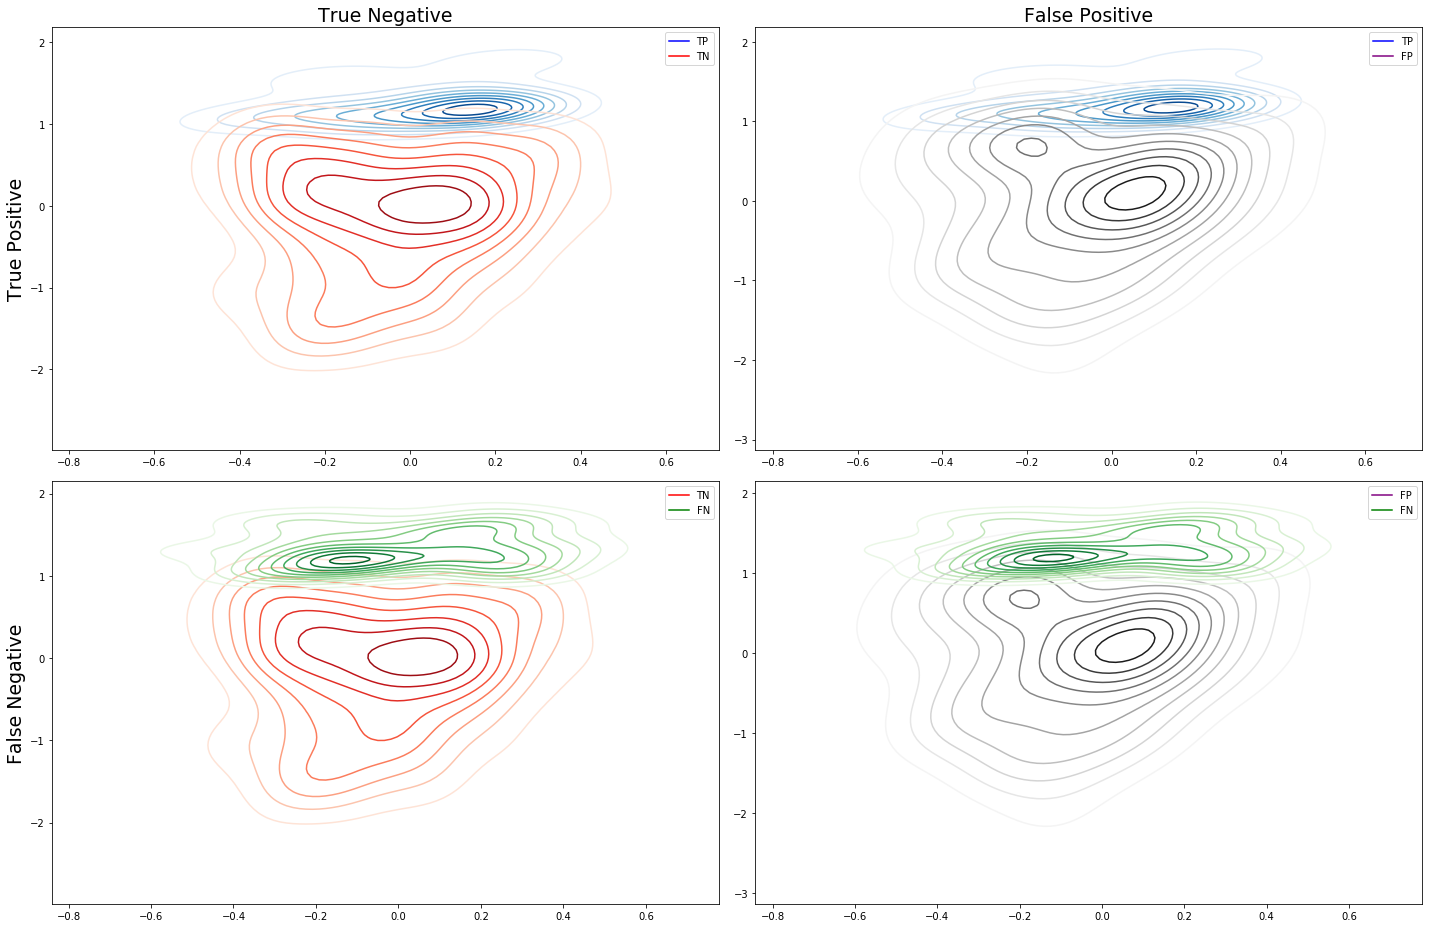

In [58]:
f,ax = plt.subplots(2,2, figsize=[20,13])

#plot TP vs TN in top left
sns.kdeplot(tp[feature].values, tp[y_axis_col], cmap="Blues", shade=False,label='TP',ax=ax[0,0])
sns.kdeplot(tn[feature].values, tn[y_axis_col], cmap="Reds", shade=False,label='TN',ax=ax[0,0])
ax[0,0].legend()
ax[0,0].set_title("True Negative",fontsize="19")
ax[0,0].set_ylabel("True Positive",fontsize="19")
leg = ax[0,0].get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')

#plot TP vs FP in top right
sns.kdeplot(tp[feature].values, tp[y_axis_col], cmap="Blues", shade=False,label='TP',ax=ax[0,1])
sns.kdeplot(fp[feature].values, fp[y_axis_col], cmap="Greys", shade=False,label='FP',ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_title("False Positive",fontsize="19")
ax[0,1].set_ylabel("")
leg = ax[0,1].get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('purple')

#plot TN vs FN in bottom left
sns.kdeplot(tn[feature].values, tn[y_axis_col], cmap="Reds", shade=False,label='TN',ax=ax[1,0])
sns.kdeplot(fn[feature].values, fn[y_axis_col], cmap="Greens", shade=False,label='FN',ax=ax[1,0])
ax[1,0].legend()
ax[1,0].set_ylabel("False Negative",fontsize="19")
leg = ax[1,0].get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('green')

#plot FP vs FN in bottom right
sns.kdeplot(fp[feature].values, fp[y_axis_col], cmap="Greys", shade=False,label='FP',ax=ax[1,1])
sns.kdeplot(fn[feature].values, fn[y_axis_col], cmap="Greens", shade=False,label='FN',ax=ax[1,1])
ax[1,1].legend()
ax[1,1].set_ylabel("")
leg = ax[1,1].get_legend()
leg.legendHandles[0].set_color('purple')
leg.legendHandles[1].set_color('green')


f.tight_layout()




# REMAKE: Percent Stable per Feature Barplot

In [43]:
def stability_probabilities_barplt(feature,df,step=0.1,topology_label='all',stability_bool=False,stable_col='stable?',by_binary=False):
    """
    Takes a dataframe and returns the list of probabilities that the protein will be either stable 
    or unstable for each value in the bin_list.
    
    Takes a list of bin values, a target feature, a topoogy,a stability target (stable or unstable),
    and a name for the stability column to use as reference. 
    """
    #get bin_list
    bin_list = create_bin_list(df, feature, step)
    print("Step 1: Made a list of bins")
    print("--> %s" %bin_list)
    print("LEN --> %s"%len(bin_list))
    
    #create a df with binned_values
    df = get_binned_df(df, feature, bin_list=bin_list,stable_col=stable_col,by_binary=by_binary)
    print("Step 2: Made a dataframe that had the 'bin value' of each row.")
    print("'binned values column: \n",df['binned_values'].values)
    
    #make a list of tuple percents of being stable or unstable depending on bin value
    percents_list,totals_list, stable_count, unstable_count = get_percents_list(df, bin_list, stable_col=stable_col) 
    print("Step 3: Made a list of percent of stable vs. unstable in each bin")
    print("List of these percentages:",percents_list)
    
    print("Totals list:",totals_list)
    print("LEN --> %s"%len(totals_list))
    
    
    stability_list = [i[0] for i in percents_list] if stability_bool==True else [i[1] for i in percents_list]

    print("LEN STABILITY LIST\n -->%s"%len(stability_list))
    
    f,ax = bar_plot(bin_list,stability_list,stability_bool,totals_list,step)
    
    #plot number of stable and unstable
#     plt.scatter(x=bin_list, y=stable_count,label='number of stable',color='black')
#     plt.scatter(x=bin_list, y=unstable_count,label='number of unstable')
    plt.legend()
    
    
    return f,ax

In [4]:
def create_bin_list(df, feature, step):
    #create bin_list
    max_feature_val = round(max(df[feature]),2)
    min_feature_val = round(min(df[feature]),2)
    bin_list = np.arange(min_feature_val,max_feature_val+step,step)
    return bin_list

In [5]:
def get_binned_df(df,feature, bin_list,pred_col=None, stable_col='stable?',by_binary=False):
    
    # get indices through digitize_bins
    ind = digitize_bins(df=df, feature=feature, bin_values_list=bin_list)
    
    # get binned_values
    binned_values = get_binned_values(ind, bin_list=bin_list)
    
    # add binned_values to df
    df['binned_values'] = binned_values
    
    return df

In [6]:
def digitize_bins(df,feature, bin_values_list):
    """
    Takes a dataframe, specified features, and bin values
    and returns indices for the df values for the bin values.
    
    Example usage:
    >>> df = pd.DataFrame([[0,4,2,6,3,2],[1,4,2,1,3,2],[12,4,1,2,2,4]])
    >>> digitize_bins(df, feature=0, bin_values_list=[2,4])
    array([0, 0, 2])
    
    """
    x = df[feature].values
    inds = np.digitize(x,bin_values_list,right=True)
    inds = chk_inds(inds, len(bin_values_list))
    return inds
    

In [7]:
def get_binned_values(ind, bin_list):
#     print('bin_list:',bin_list)
#     print('max ind:',max(list(ind)))
    binned_values=[]
    for i in ind:
        #print(i)
        binned_values.append(bin_list[i])
    return binned_values

In [8]:
def get_percents_list(df, bin_list, stable_col='stable?'):
    
    percents_list = []
    totals_list = []
    
    stable_count = []
    unstable_count = []
    
    for i in bin_list:
        # find where df has 
        specified_df = df[df['binned_values']==i].copy()
        
        # find positive and negatives values to for this VAL specific df
        stable, unstable = specified_df[specified_df[stable_col]==1].copy(), specified_df[specified_df[stable_col]==0].copy()
        
        # get number of stable and unstable examples
        n_stable = len(stable)
        n_unstable = len(unstable)
        #if the sum of stable and unstable is 0, then make 'total' slightly non-zero to not break code
        total = n_stable+n_unstable if (n_stable+n_unstable)!=0 else 0.0000000001 
        
        #keep track of how many stable and unstables we have per bin, for debugging
        stable_count.append(n_stable)
        unstable_count.append(n_unstable)
        
        # get percent of positive and negative
        p_stable = n_stable/(total)
        p_unstable = n_unstable/(total)
        
        percents_list.append((p_stable,p_unstable))
        totals_list.append(total)
    
    return percents_list, totals_list, stable_count,unstable_count
     

In [9]:
def specify_stability(probabilities_list, stability_bool):
    stability_list = []
    tuple_inx = None
    if stability_bool:
        tuple_inx=0
    else:
        tuple_inx=1
    for i in probabilities_list:
        stability_list.append(i[tuple_inx])
    return stability_list
        

In [49]:
def bar_plot(bin_list, stability_list, stability_bool,totals_list,step):
    
    stability_label = 'stable' if stability_bool else 'unstable'
    
    f,ax = plt.subplots()
    plt.bar(x=[i+step for i in bin_list],height=stability_list,width=step,color='darkorange',facecolor='none',edgecolor='black')
    ax2 = ax.twinx()
    plt.scatter(x=bin_list,y=totals_list,label='protein count')
    ax2.set_ylabel("count of proteins per bin",rotation="270",fontsize='14')
    ax2.yaxis.set_label_coords(1.125,.525)
    ax2.set_ylim(bottom=0)
    ax.set_ylabel("Fraction of %s per bin"%stability_label,fontsize='14')
    ax.set_xlabel("SumE_entropies values",fontsize=14)

    return f,ax

In [11]:
def chk_inds(ndarray, max_val):
    return [(max_val-1) if x==max_val else x for x in ndarray]


In the process of regenerating plots, I found a few old functions that began to break, so I will remake some of them here

In [24]:
#get a run that was just rosetta
sample_spc_run = entropy_rosetta_runs_names[0]
#get the index of names that were in that run's testing data
spc_scatter_data = pd.read_csv('./estrada_runs/cross_val_tptn_runs/test_harness_results/runs/run_%s/testing_data.csv'%sample_spc_run)
spc_data_inx = spc_scatter_data['name'].to_list()

#get a slice the dataframe which contains only the testing data
spc_slice = df[df['name'].isin(spc_data_inx)].copy()
spc_slice['stabilityscore_cnn_calibrated_2classes_predictions'] = spc_scatter_data['stabilityscore_cnn_calibrated_2classes_predictions'].to_list()


#specify for topology
spc_slice = spc_slice[spc_slice['topology']=='EEHEE']

Step 1: Made a list of bins
--> [-3.89 -2.89 -1.89 -0.89  0.11  1.11  2.11  3.11  4.11  5.11  6.11  7.11
  8.11  9.11 10.11 11.11 12.11 13.11]
LEN --> 18
Step 2: Made a dataframe that had the 'bin value' of each row.
'binned values column: 
 [ 6.11  5.11  3.11 ... 11.11  3.11  6.11]
Step 3: Made a list of percent of stable vs. unstable in each bin
List of these percentages: [(0.0, 1.0), (0.0, 0.0), (0.0, 0.0), (0.0, 1.0), (0.1, 0.9), (0.20833333333333334, 0.7916666666666666), (0.2534246575342466, 0.7465753424657534), (0.15584415584415584, 0.8441558441558441), (0.09876543209876543, 0.9012345679012346), (0.043478260869565216, 0.9565217391304348), (0.028070175438596492, 0.9719298245614035), (0.011320754716981131, 0.9886792452830189), (0.02185792349726776, 0.9781420765027322), (0.01098901098901099, 0.989010989010989), (0.023809523809523808, 0.9761904761904762), (0.0, 1.0), (0.5, 0.5), (0.0, 1.0)]
Totals list: [1, 1e-10, 1e-10, 3, 10, 48, 146, 231, 324, 299, 285, 265, 183, 91, 42, 12, 2, 1]

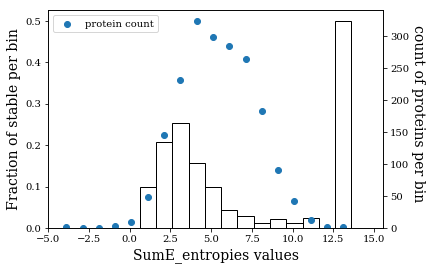

In [52]:
f, ax = stability_probabilities_barplt('SumE_entropies',
                               spc_slice, 
                               stable_col='stabilityscore_cnn_calibrated_2classes',
                               stability_bool=True,
                               step=1)

#plt.title("Percent of proteins stable per sum of \nbeta-sheet residues' entropy in EEHEE topology",fontsize='16')
plt.legend(loc='upper left')

plt.show()

Step 1: Made a list of bins
--> [-3.89 -2.89 -1.89 -0.89  0.11  1.11  2.11  3.11  4.11  5.11  6.11  7.11
  8.11  9.11 10.11 11.11 12.11 13.11]
LEN --> 18
Step 2: Made a dataframe that had the 'bin value' of each row.
'binned values column: 
 [ 6.11  5.11  3.11 ... 11.11  3.11  6.11]
Step 3: Made a list of percent of stable vs. unstable in each bin
List of these percentages: [(0.0, 1.0), (0.0, 0.0), (0.0, 0.0), (0.0, 1.0), (0.1, 0.9), (0.20833333333333334, 0.7916666666666666), (0.2534246575342466, 0.7465753424657534), (0.15584415584415584, 0.8441558441558441), (0.09876543209876543, 0.9012345679012346), (0.043478260869565216, 0.9565217391304348), (0.028070175438596492, 0.9719298245614035), (0.011320754716981131, 0.9886792452830189), (0.02185792349726776, 0.9781420765027322), (0.01098901098901099, 0.989010989010989), (0.023809523809523808, 0.9761904761904762), (0.0, 1.0), (0.5, 0.5), (0.0, 1.0)]
Totals list: [1, 1e-10, 1e-10, 3, 10, 48, 146, 231, 324, 299, 285, 265, 183, 91, 42, 12, 2, 1]

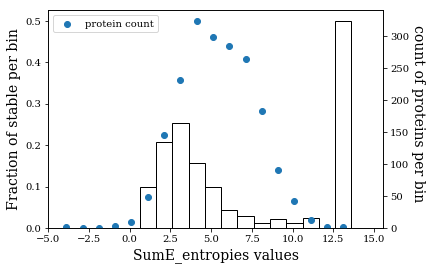

In [50]:
f, ax = stability_probabilities_barplt('SumE_entropies',
                               spc_slice, 
                               stable_col='stabilityscore_cnn_calibrated_2classes',
                               stability_bool=True,
                               step=1)

plt.legend(loc='upper left')
plt.xlabel("SumE_entropies value",fontsize='14')
#plt.title("Percent of proteins stable per sum \nof beta sheet residue entropy in EEHEE topology",fontsize='16')
plt.savefig("Figure3b",dpi=300,bbox_inches="tight")

Step 1: Made a list of bins
--> [-0.67 -0.57 -0.47 -0.37 -0.27 -0.17 -0.07  0.03  0.13  0.23  0.33  0.43
  0.53]
LEN --> 13
Step 2: Made a dataframe that had the 'bin value' of each row.
'binned values column: 
 [-0.07  0.03 -0.07 ... -0.17 -0.07 -0.37]
Step 3: Made a list of percent of stable vs. unstable in each bin
List of these percentages: [(0.0, 0.0), (0.5, 0.5), (0.047619047619047616, 0.9523809523809523), (0.03225806451612903, 0.967741935483871), (0.039603960396039604, 0.9603960396039604), (0.026865671641791045, 0.9731343283582089), (0.02, 0.98), (0.05063291139240506, 0.9493670886075949), (0.14726027397260275, 0.8527397260273972), (0.1722689075630252, 0.8277310924369747), (0.20512820512820512, 0.7948717948717948), (0.09090909090909091, 0.9090909090909091), (0.0, 1.0)]
Totals list: [1e-10, 4, 21, 93, 202, 335, 350, 316, 292, 238, 78, 11, 3]
LEN --> 13
LEN STABILITY LIST
 -->13


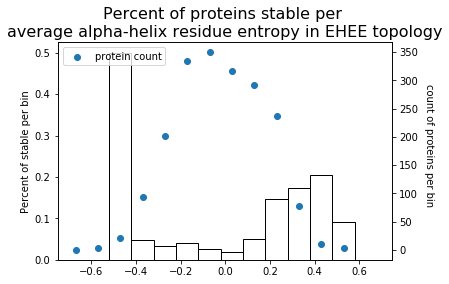

In [71]:
f, ax = stability_probabilities_barplt('Mean_H_entropy',
                               spc_slice, 
                               stable_col='stabilityscore_cnn_calibrated_2classes',
                               stability_bool=True,
                               step=.1)
plt.title("Percent of proteins stable per \naverage alpha-helix residue entropy in EHEE topology",fontsize='16')
plt.legend(loc='upper left')

In [72]:
# I want to make sure that I'm not fooling myself

max_bin = spc_slice['binned_values'].max()
max_bin_df = spc_slice[spc_slice['binned_values']==max_bin]


stable_count = 0
unstable_count = 0 

for i in max_bin_df['stabilityscore_cnn_calibrated_2classes']:
    if i==True:
        stable_count+=1
    elif i==False:
        unstable_count+=1

        
print("MAX VAL: %s"%max_bin)
print("TOTAL STABLE: %s"%stable_count)
print("TOTAL UNSTABLE %s"%unstable_count)
print("PERCENT STABLE: %s"%(stable_count/(stable_count+unstable_count)))

MAX VAL: 0.5299999999999997
TOTAL STABLE: 0
TOTAL UNSTABLE 3
PERCENT STABLE: 0.0


# REMAKE: KS values for entire dataset

In [73]:
def plot_distributions(fet,top):
    stable_top = stable_proteins[stable_proteins['topology']==top]
    unstable_top = unstable_proteins[unstable_proteins['topology']==top]




    sns.kdeplot(stable_top[fet],label='stable',shade=True)
    sns.kdeplot(unstable_top[fet],label='unstable',shade=True)
    plt.title("%s for %s topology"%(fet,top))
    plt.show()
    
    
    plt.close('all')
    length_1 = len(stable_top[fet].values)
    length_2 = len(unstable_top[fet].values)


    plotting_df = pd.DataFrame()
    plotting_df['class'] = ['stable']*length_1+['unstable']*length_2
    plotting_df['values'] = np.append(stable_top[fet].values,unstable_top[fet].values)

    sns.stripplot(x='values',y='class',data=plotting_df)
    
    ax = sns.boxplot(x='values',y='class',data=plotting_df)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .2))
        
    ax.set_ylabel("")
    
    
    plt.title("%s in %s topology"%(fet,top))
    plt.show()
    plt.close('all')

In [74]:
# will have a table that has the KS value between stable and unstable for each S_cnf feature

In [75]:
#load data
df = pd.read_csv("./dataframes/df_aggregated_spc.csv")
df['stabilityscore_cnn_calibrated_2classes'] = df['stabilityscore_cnn_calibrated'] > 1

#NTF2 topology should not be used so remove those rows
ntf2_inx = df[df['topology']=='NTF2'].index
df = df.drop(ntf2_inx)

In [76]:
#get list names for entropy features
spc_features = pd.read_csv('./entropy_features.csv')["0"].to_list()

#get lsit names for rosetta features
ros_features = pd.read_csv('./rosetta_features.csv')["0"].to_list()
#create a list of all topologies
topologies = list(df['topology'].unique())

#split up dataframe into stable and unstable proteins
stable_proteins = df[df['stabilityscore_cnn_calibrated_2classes']==1]
unstable_proteins = df[df['stabilityscore_cnn_calibrated_2classes']==0]

### Generate the data

In [77]:
rows = []
for fet in spc_features:
    subset_stable = stable_proteins[fet]
    subset_unstable = unstable_proteins[fet]
    
    ks_value, p_value = ks_2samp(subset_stable,subset_unstable)
    rows.append([fet,ks_value,False,p_value]) #third row corresponds to 'is_rosetta' column

for fet in ros_features:
    subset_stable = stable_proteins[fet]
    subset_unstable = unstable_proteins[fet]
    
    ks_value, p_value = ks_2samp(subset_stable,subset_unstable)
    rows.append([fet,ks_value,True,p_value])

    
    

In [78]:
ks_values_all = pd.DataFrame(rows,columns=['Feature','KS','is_rosetta','P-value'])

In [79]:
ks_values_all_spc = ks_values_all[ks_values_all['is_rosetta']==False]
ks_values_all_ros = ks_values_all[ks_values_all['is_rosetta']==True]

In [80]:
spc_max_inx = ks_values_all_spc['KS'].idxmax()
ros_max_inx = ks_values_all_ros['KS'].idxmax()

### Sanity check to make sure the dataframe agrees with previous work 

In [81]:
ks_values_all.iloc[spc_max_inx,:]

Feature       E_max_entropy
KS                 0.233719
is_rosetta            False
P-value                   0
Name: 14, dtype: object

In [82]:
ks_values_all.iloc[ros_max_inx,:]

Feature       avg_best_frag
KS                 0.361311
is_rosetta             True
P-value                   0
Name: 27, dtype: object

### Now get top features for S$_{cnf}$ per KS values

In [83]:
ks_values_all_spc[ks_values_all_spc['P-value']<.05].sort_values(by='KS',ascending=False)

,Feature,KS,is_rosetta,P-value
16,E_range_entropy,0.233719,False,0.000000e+00
14,E_max_entropy,0.233719,False,0.000000e+00
15,E_min_entropy,0.233253,False,0.000000e+00
3,Mean_E_entropy,0.219145,False,0.000000e+00
7,SumE_entropies,0.219145,False,0.000000e+00
12,L_min_entropy,0.184505,False,1.264329e-292
2,Mean_L_entropy,0.161355,False,6.686678e-224
10,H_range_entropy,0.144643,False,5.250187e-180
8,H_max_entropy,0.135258,False,1.859491e-157
0,S_PC,0.105591,False,3.975463e-96


### Important Result:
`E_max_entropy` has a higher **KS** value than 112 Rosetta features, when comparing distributions between stable and unstable proteins without specifying for topology

In [84]:
print(ks_values_all.sort_values(by='KS',ascending=False)[['Feature','KS','P-value']].reset_index(drop=True).to_string())

                        Feature        KS        P-value
0                 avg_best_frag  0.361311   0.000000e+00
1                 avg_all_frags  0.354210   0.000000e+00
2          mismatch_probability  0.324384   0.000000e+00
3                   worst6frags  0.287130   0.000000e+00
4                sum_best_frags  0.283294   0.000000e+00
5     abego_res_profile_penalty  0.279034   0.000000e+00
6                     worstfrag  0.278745   0.000000e+00
7               net_atr_per_res  0.278246   0.000000e+00
8                fa_atr_per_res  0.269890   0.000000e+00
9                      hxl_tors  0.262143   0.000000e+00
10                   nres_helix  0.253138   0.000000e+00
11                score_per_res  0.248123   0.000000e+00
12                  hbond_sr_bb  0.247241   0.000000e+00
13            buried_np_per_res  0.241876   0.000000e+00
14                   frac_helix  0.240630   0.000000e+00
15                    nres_loop  0.236987   0.000000e+00
16        hbond_lr_bb_per_sheet

### Redo, but with topology column included

In [85]:
rows = []

for topology in topologies:
    stable_top_specific = stable_proteins[stable_proteins['topology']==topology]
    unstable_top_specific = unstable_proteins[unstable_proteins['topology']==topology]
    

    for fet in spc_features:
        subset_stable = stable_top_specific[fet]
        subset_unstable = unstable_top_specific[fet]

        ks_value, p_value = ks_2samp(subset_stable,subset_unstable)
        rows.append([fet,ks_value,False,topology,p_value]) #third row corresponds to 'is_rosetta' column

    for fet in ros_features:
        subset_stable = stable_top_specific[fet]
        subset_unstable = unstable_top_specific[fet]

        ks_value, p_value = ks_2samp(subset_stable,subset_unstable)
        rows.append([fet,ks_value,True,topology,p_value])
    
    

In [86]:
ks_values_topology = pd.DataFrame(rows,columns=['Feature','KS','is_rosetta','Topology','P-value'])
ks_values_topology_spc = ks_values_topology[ks_values_topology['is_rosetta']==False]
ks_values_topology_ros = ks_values_topology[ks_values_topology['is_rosetta']==True]

In [87]:
ks_values_topology[ks_values_topology['P-value']<.05].sort_values(by='KS',ascending=False)

,Feature,KS,is_rosetta,Topology,P-value
1083,contig_not_hp_avg,0.648746,True,EEHEE,9.290693e-240
1091,exposed_np_AFILMVWY,0.635489,True,EEHEE,4.465466e-230
1142,net_atr_net_sol_per_res,0.623621,True,EEHEE,1.404286e-221
1084,contig_not_hp_avg_norm,0.611012,True,EEHEE,9.994632e-213
1075,buried_np_AFILMVWY_per_res,0.604424,True,EEHEE,3.574334e-208
...,...,...,...,...,...
1307,SumE_entropies,0.036162,False,HEEH,1.898156e-02
1337,buried_over_exposed,0.035344,True,HEEH,2.337832e-02
1391,n_hphob_clusters,0.034972,True,HEEH,2.565842e-02
1318,T1_absq,0.033785,True,HEEH,3.431151e-02


In [88]:
ks_values_topology_spc[ks_values_topology_spc['P-value']<.05].sort_values(by='KS',ascending=False)

,Feature,KS,is_rosetta,Topology,P-value
1047,SumE_entropies,0.421752,False,EEHEE,1.414491e-101
1045,SumH_entropies,0.410102,False,EEHEE,4.588637e-96
1041,Mean_H_entropy,0.409991,False,EEHEE,5.169506e-96
654,Mean_res_entropy,0.357826,False,coil,2.384891e-03
788,H_max_entropy,0.336146,False,fold4,3.459011e-02
...,...,...,...,...,...
141,L_max_entropy,0.047862,False,ferredoxin,1.748377e-02
10,H_range_entropy,0.046820,False,4h,6.141417e-03
144,E_max_entropy,0.044779,False,ferredoxin,3.156998e-02
12,L_min_entropy,0.041484,False,4h,2.129706e-02


Text(0.5, 1.0, 'SumE_entropies in EEHEE topology')

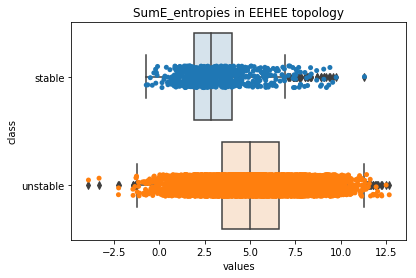

In [89]:
fet='SumE_entropies'
top='EEHEE'

stable_top = stable_proteins[stable_proteins['topology']==top]
unstable_top = unstable_proteins[unstable_proteins['topology']==top]


length_1 = len(stable_top[fet].values)
length_2 = len(unstable_top[fet].values)


plotting_df = pd.DataFrame()
plotting_df['class'] = ['stable']*length_1+['unstable']*length_2
plotting_df['values'] = np.append(stable_top[fet].values,unstable_top[fet].values)

sns.stripplot(x='values',y='class',data=plotting_df)

ax = sns.boxplot(x='values',y='class',data=plotting_df)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))

plt.title("%s in %s topology"%(fet,top))


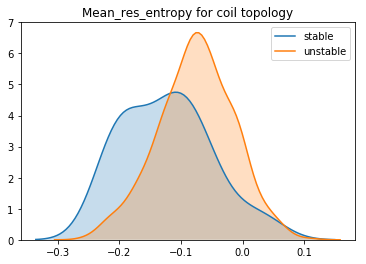

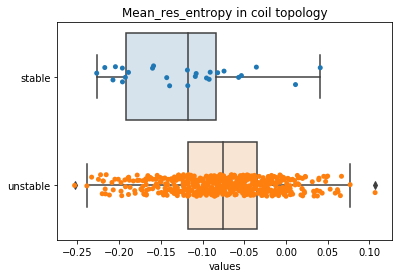

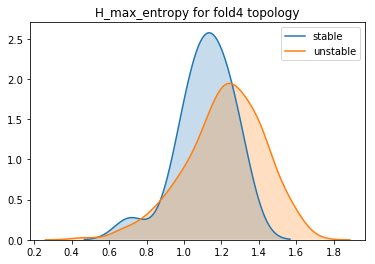

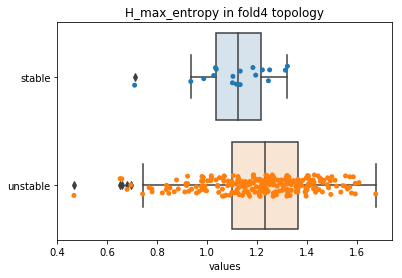

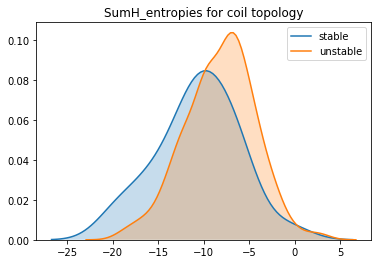

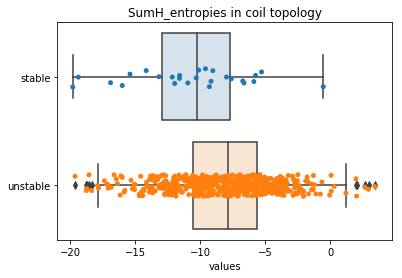

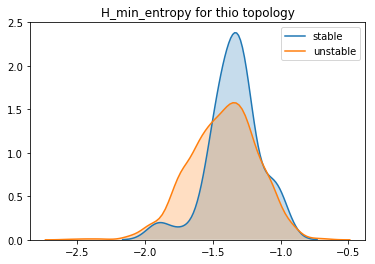

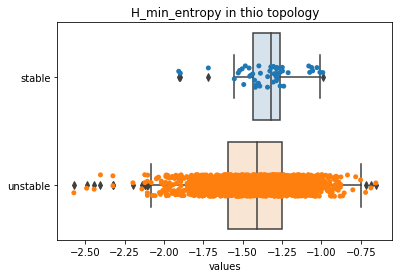

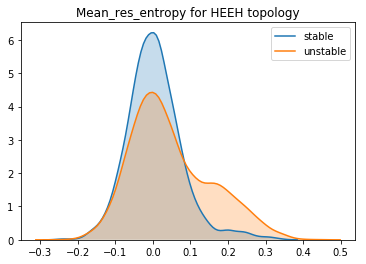

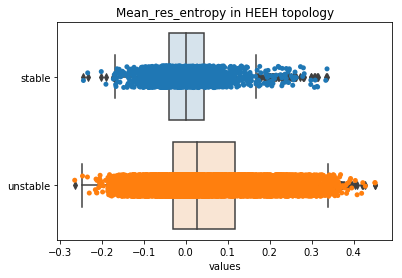

In [90]:
for fet,top in [("Mean_res_entropy",'coil'),('H_max_entropy','fold4'),('SumH_entropies','coil'),('H_min_entropy','thio'),('Mean_res_entropy','HEEH')]:
    plot_distributions(fet,top)

Step 1: Made a list of bins
--> [-2.50000000e-01 -2.00000000e-01 -1.50000000e-01 -1.00000000e-01
 -5.00000000e-02 -5.55111512e-17  5.00000000e-02  1.00000000e-01
  1.50000000e-01]
LEN --> 9
Step 2: Made a dataframe that had the 'bin value' of each row.
'binned values column: 
 [ 5.00000000e-02  5.00000000e-02  5.00000000e-02 -5.55111512e-17
 -5.55111512e-17 -2.00000000e-01 -1.00000000e-01 -1.00000000e-01
 -5.00000000e-02 -5.00000000e-02 -1.00000000e-01 -1.00000000e-01
 -1.50000000e-01 -1.00000000e-01 -5.00000000e-02 -5.00000000e-02
 -1.00000000e-01 -5.00000000e-02 -1.00000000e-01 -5.00000000e-02
 -5.55111512e-17 -5.55111512e-17 -5.55111512e-17 -5.55111512e-17
 -5.00000000e-02 -1.50000000e-01 -1.00000000e-01 -5.00000000e-02
 -5.55111512e-17 -5.00000000e-02  5.00000000e-02 -5.55111512e-17
 -5.00000000e-02 -5.55111512e-17 -5.55111512e-17 -1.50000000e-01
 -5.00000000e-02 -5.55111512e-17 -5.55111512e-17 -2.00000000e-01
 -5.00000000e-02  5.00000000e-02 -5.00000000e-02 -5.00000000e-02
 -2.000

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(0.0, 0.5)

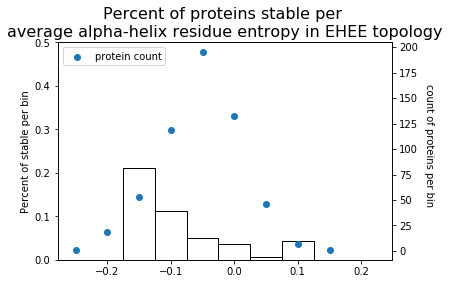

In [91]:
f, ax = stability_probabilities_barplt('Mean_res_entropy',
                               df[df['topology']=='coil'], 
                               stable_col='stabilityscore_cnn_calibrated_2classes',
                               stability_bool=True,
                               step=.05)
plt.title("Percent of proteins stable per \naverage alpha-helix residue entropy in EHEE topology",fontsize='16')
plt.legend(loc='upper left')
ax.set_ylim(top=.5)